In [1]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
import itertools
# помещаем графику внутрь блокнота
%matplotlib inline

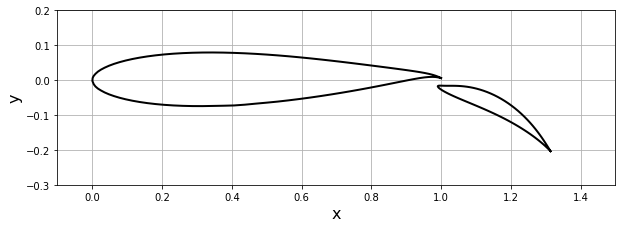

In [2]:
NumberOfPanels = 100 # количество панелей

## геометрия главной части
naca_filepath = os.path.join('MainFoil_N=100.csv')
with open (naca_filepath, 'r') as file_name:
    x_main, y_main = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)

## геометрия закрылки 
naca_filepath = os.path.join('FlapFoil_N=100.csv')
with open (naca_filepath, 'r') as file_name:
    x_flap, y_flap = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)


# рисуем геометрию
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.2)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2);

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # начальная точка панели
        self.xb, self.yb = xb, yb # конечная точка панели
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # центр панели
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # длина панели
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # расположение панели
        if self.beta <= numpy.pi:
            self.loc = 'upper' # верхняя поверхность
        else:
            self.loc = 'lower' # нижняя поверхность
        
        self.sigma = 0.0 # интенсивность источника
        self.vt = 0.0    # касательная скорость
        self.cp = 0.0    # коэффициент давления
        self.gamma = 0.0 # циркуляция
        

In [4]:
def define_panels(x, y, N):
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [5]:
# разбиваем геометрию на панели
panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)

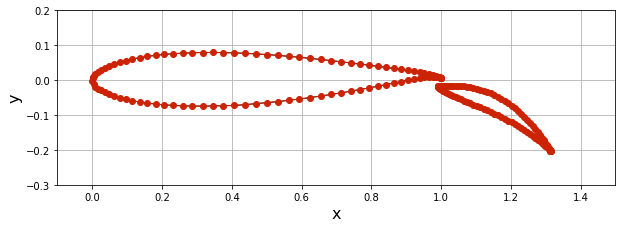

In [6]:
# рисуем дискретизированую геометрию
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=1)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=1)
pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa),
            numpy.append([panel.ya for panel in panels_main], panels_main[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305')

pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa),
            numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305')

pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.2);

In [7]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы
# задаем параметры набегающего потока
freestream = Freestream(u_inf=1.0, alpha=0.0)


In [8]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [9]:
def source_contribution_normal(panels_first, panels_second):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels_first.size + panels_second.size, panels_first.size + panels_second.size), dtype=float)
    # вклад рассматриваемой панели в общее поле источников
    numpy.fill_diagonal(A, 0.5)
    # вклад остальных панелей
    for i, panel_i in enumerate(itertools.chain(panels_first,panels_second)):
        for j, panel_j in enumerate(itertools.chain(panels_first,panels_second)):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [10]:
def vortex_contribution_normal(panels_first, panels_second):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels_first.size + panels_second.size, panels_first.size + panels_second.size), dtype=float)
    # вклад от рассматриваемой панели в поле вихря
    numpy.fill_diagonal(A, 0.0)
    # вихревой вклад от всех остальных панелей
    for i, panel_i in enumerate(itertools.chain(panels_first,panels_second)):
        for j, panel_j in enumerate(itertools.chain(panels_first,panels_second)):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [11]:
A_source = source_contribution_normal(panels_main, panels_flap)
B_vortex = vortex_contribution_normal(panels_main, panels_flap)

In [12]:
def kutta_condition(A_source, B_vortex):
    global NumberOfPanels
    """
    Builds the Kutta condition array.
    """
    Na = NumberOfPanels
    b = numpy.empty((2, A_source.shape[0] + 2), dtype=float)
    b[0,:-2] = B_vortex[0, : ] + B_vortex[Na-1, : ]
    b[0,-1] = - numpy.sum(A_source[0, Na: ] + A_source[Na-1, Na: ])
    b[0,-2] = - numpy.sum(A_source[0, :Na] + A_source[Na-1, :Na])
    
    b[1,:-2] = B_vortex[Na, : ] + B_vortex[-1, : ]
    b[1,-1] = - numpy.sum(A_source[Na, Na: ] + A_source[-1, Na: ])
    b[1,-2] = - numpy.sum(A_source[Na, :Na] + A_source[-1, :Na])
    return b

In [13]:
def build_singularity_matrix(A_source, B_vortex):
    global NumberOfPanels
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    Na = NumberOfPanels
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
                    
    # матрица источников
    A[:-2, :-2] = A_source
    # матрица вихрей
    A[:-2,-2] = numpy.sum(B_vortex[:,:Na], axis=1).transpose() 
    A[:-2,-1] = numpy.sum(B_vortex[:,Na:], axis=1)
    # условие Кутты-Жуковского
    A[-2:, :] = kutta_condition(A_source, B_vortex) 
    return A


In [14]:
def build_freestream_rhs(panels_first, panels_second, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels_first.size + panels_second.size + 2,dtype=float)
    # вклад от набегающего потока в каждую панель
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # вклад от набегающего потока в условие Кутты-Жуковского
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels_first[0].beta)
                               +numpy.sin(freestream.alpha-panels_first[-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels_second[0].beta)
                               +numpy.sin(freestream.alpha-panels_second[-1].beta) )
    return b


In [15]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_main, panels_flap, freestream)


In [16]:
# рассчитываем интенсивности источников и вихря
strengths = numpy.linalg.solve(A, b)

# заполняем интенсивности на кажой панели
for i , panel in enumerate(panels_main):
    panel.sigma = strengths[i]
    panel.gamma = strengths[-2]
for i , panel in enumerate(panels_flap):
    panel.sigma = strengths[i+panels_flap.size]
    panel.gamma = strengths[-1]

### Коэффициент давления на поверхности 

In [17]:
def compute_tangential_velocity(panels_first,panels_second, freestream, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    """
    A = numpy.empty((panels_first.size + panels_second.size, panels_first.size + panels_second.size + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    A[:, -2] = -numpy.sum(A_source[:,:panels_first.size], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,panels_first.size:], axis=1)
    # добавляем набегающий поток
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in itertools.chain(panels_first,panels_second)])
    strengths = numpy.empty( (panels_first.size + panels_second.size+2,),dtype=float)  #shape (102,)
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        strengths[i] = panel.sigma
    strengths[-2] = panels_first[0].gamma
    strengths[-1] = panels_second[0].gamma
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        panel.vt = tangential_velocities[i]

In [18]:
# касательная компонента скорости на каждой панели
compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)


In [19]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2
        

In [20]:
# коэффициент давления на поверхности
compute_pressure_coefficient(panels_main, freestream) 
compute_pressure_coefficient(panels_flap, freestream)


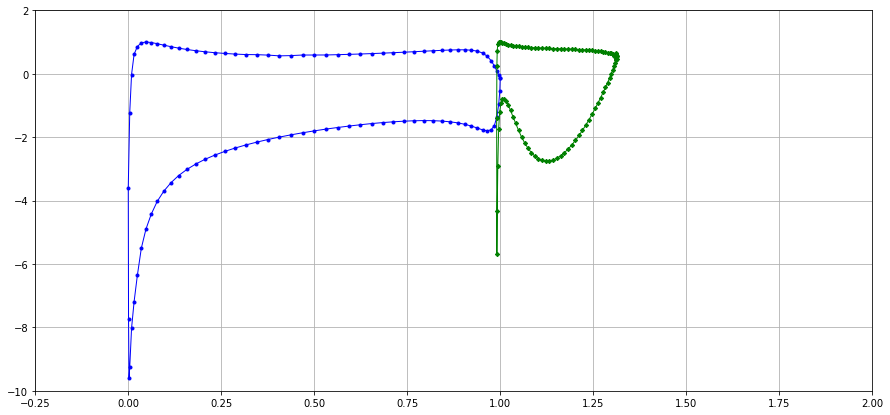

In [21]:
# рисуем коэффициент давления на поверхности
pyplot.figure(figsize=(15, 7))
pyplot.grid()
pyplot.plot(x_main[:-1], [panel.cp for panel in panels_main], color='blue', linestyle='-',
            marker='o', markersize=3,linewidth=1)
pyplot.plot(x_flap[:-1], [panel.cp for panel in panels_flap], color='green', linestyle='-',
            marker='D', markersize=3,linewidth=1)
pyplot.xlim(-0.25, 2)
pyplot.ylim(-10, 2);

In [22]:
accuracy = sum([panel.sigma*panel.length for panel in itertools.chain(panels_main,panels_flap)])
print('суммарная интенсивность особенностей: {:0.8f}'.format(accuracy))

суммарная интенсивность особенностей: -0.00174836


In [23]:
c_main = abs(max(panel.xa for panel in panels_main)
        - min(panel.xa for panel in panels_main))
c_flap = abs(max(panel.xa for panel in panels_flap)
        - min(panel.xa for panel in panels_flap))

Cl = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
       panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / (0.5*freestream.u_inf*(c_main) )
print('коэффициент подъемной силы: CL = {:0.4f}'.format(Cl))


коэффициент подъемной силы: CL = 3.7246


In [24]:
Cx = 0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    Cx += (panel.yb - panel.ya)*panel.cp
print(Cx)

Cy = 0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    Cy += (panel.xb - panel.xa)*panel.cp

print(Cy)

0.010791403245871316
3.6977144768607526


### Тест Вензингера

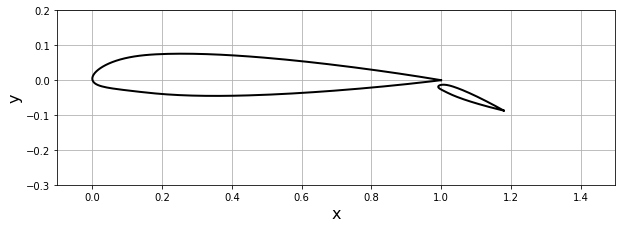

In [25]:
NumberOfPanels = 150
x0 = 1.03
y0 = -0.054
angle = 20*math.pi/180

naca_filepath = os.path.join('NACA23012_MainFoil.csv')
with open (naca_filepath, 'r') as file_name:
    x_main, y_main = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)
    
naca_filepath = os.path.join('NACA23012_FlapFoil.csv')
with open (naca_filepath, 'r') as file_name:
    x_flap_s, y_flap_s = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)
    

x_flap = x0 + (x_flap_s-x0)*math.cos(angle) + (y_flap_s - y0)*math.sin(angle)
y_flap = y0 - (x_flap_s-x0)*math.sin(angle) + (y_flap_s - y0)*math.cos(angle)

width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.2);


In [26]:
# разбиваем геометрию на панели
panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)


In [27]:
angle_freestreem = 0.0
freestream = Freestream(u_inf=1.0, alpha=angle_freestreem)


In [28]:
A_source = source_contribution_normal(panels_main, panels_flap)
B_vortex = vortex_contribution_normal(panels_main, panels_flap)


In [29]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_main, panels_flap, freestream)


In [30]:
# рассчитываем интенсивности источников и вихря
strengths = numpy.linalg.solve(A, b)

# заполняем интенсивности на кажой панели
for i , panel in enumerate(panels_main):
    panel.sigma = strengths[i]
    panel.gamma = strengths[-2]
for i , panel in enumerate(panels_flap):
    panel.sigma = strengths[i+panels_flap.size]
    panel.gamma = strengths[-1]
    

In [31]:
# касательная компонента скорости на каждой панели
compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
# коэффициент давления на поверхности
compute_pressure_coefficient(panels_main, freestream)
compute_pressure_coefficient(panels_flap, freestream)


In [32]:
c_main = abs(max(panel.xa for panel in panels_main)- min(panel.xa for panel in panels_main))
c_flap = abs(max(panel.xa for panel in panels_flap)- min(panel.xa for panel in panels_flap))

cl = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
       panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / \
            (0.5*freestream.u_inf*(c_main + c_flap))
print('коэффициент подъемной силы: CL = {:0.4f}'.format(cl))


коэффициент подъемной силы: CL = 1.2874


In [33]:
Cx = 0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    Cx += (panel.yb - panel.ya)*panel.cp
print(Cx)

Cy = 0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    Cy += (panel.xb - panel.xa)*panel.cp
print(Cy)


-3.764985384204067e-05
1.5201862605266299


In [ ]:
# задаем параметры набегающего потока в градусах
a = -14
b = 14
while True: 
    freestream = Freestream(u_inf=1.0, alpha=(a + b)/2 )
    A_source = source_contribution_normal(panels_main, panels_flap)
    B_vortex = vortex_contribution_normal(panels_main, panels_flap)
    A = build_singularity_matrix(A_source, B_vortex)
    _b = build_freestream_rhs(panels_main, panels_flap, freestream)
    strengths = numpy.linalg.solve(A, _b)
    for i , panel in enumerate(panels_main):
        panel.sigma = strengths[i]
        panel.gamma = strengths[-2]
    for i , panel in enumerate(panels_flap):
        panel.sigma = strengths[i+panels_flap.size]
        panel.gamma = strengths[-1]
    
    compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
    compute_pressure_coefficient(panels_main, freestream)
    compute_pressure_coefficient(panels_flap, freestream)

    c_main = abs(max(panel.xa for panel in panels_main)- min(panel.xa for panel in panels_main))
    c_flap = abs(max(panel.xa for panel in panels_flap)- min(panel.xa for panel in panels_flap))

    cl_new = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
           panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) /\
                (0.5*freestream.u_inf*(c_main + c_flap))
    print(cl_new)
    if cl_new > 0:
        b = (a+b)/2
    else:
        a = (a+b)/2
    print("a = ", a, "b = ", b)
    if abs(a - b) < 0.01:
        break
        

1.287376934865718
a =  -14 b =  0.0
0.46808593481995947
a =  -14 b =  -7.0
0.05505408017733331
a =  -14 b =  -10.5
-0.15163525817509974
a =  -12.25 b =  -10.5
-0.0482962207772207
a =  -11.375 b =  -10.5
0.0033790282078415674
a =  -11.375 b =  -10.9375
-0.022458759968644066
a =  -11.15625 b =  -10.9375
-0.009539883262563659
a =  -11.046875 b =  -10.9375


# №2


In [ ]:
NumberOfPanels = 150
x0 = 1.03
y0 = -0.054
naca_filepath = os.path.join('NACA23012_MainFoil.csv')
with open (naca_filepath, 'r') as file_name:
    x_main, y_main = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)
    
naca_filepath = os.path.join('NACA23012_FlapFoil.csv')
with open (naca_filepath, 'r') as file_name:
    x_flap_s, y_flap_s = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)


In [ ]:
a = -10*math.pi/180
b = 30*math.pi/180  
freestream = Freestream(u_inf = 1.0, alpha = 0.0 )
while True:
    angle = (a + b) / 2
    
    x_flap = x0 + (x_flap_s-x0)*math.cos(angle) + (y_flap_s - y0)*math.sin(angle)
    y_flap = y0 - (x_flap_s-x0)*math.sin(angle) + (y_flap_s - y0)*math.cos(angle)
    
    panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
    panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)
    
    A_source = source_contribution_normal(panels_main, panels_flap)
    B_vortex = vortex_contribution_normal(panels_main, panels_flap)
    A = build_singularity_matrix(A_source, B_vortex)
    _b = build_freestream_rhs(panels_main, panels_flap, freestream)
    strengths = numpy.linalg.solve(A, _b)
    for i , panel in enumerate(panels_main):
        panel.sigma = strengths[i]
        panel.gamma = strengths[-2]
    for i , panel in enumerate(panels_flap):
        panel.sigma = strengths[i+panels_flap.size]
        panel.gamma = strengths[-1]
    
    compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
    compute_pressure_coefficient(panels_main, freestream)
    compute_pressure_coefficient(panels_flap, freestream)

    c_main = abs(max(panel.xa for panel in panels_main)- min(panel.xa for panel in panels_main))
    c_flap = abs(max(panel.xa for panel in panels_flap)- min(panel.xa for panel in panels_flap))

    cl_new = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
               panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / \
                    (0.5*freestream.u_inf*(c_main + c_flap))
    
    print(cl_new)
    print("a = ", a/math.pi*180, "b = ", b/math.pi*180)
    if abs(a/math.pi*180 - b/math.pi*180) < 0.01:
        break
    if cl_new < 0:
        a = angle
    else:
        b = angle
    

# №3
    

In [ ]:
angle = 5*math.pi/180
freestream = Freestream(u_inf = 1.0, alpha = 4.0)

naca_filepath = os.path.join('NACA23012_MainFoil.csv')
with open (naca_filepath, 'r') as file_name:
    x_main, y_main = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)
naca_filepath = os.path.join('NACA23012_FlapFoil.csv')
with open (naca_filepath, 'r') as file_name:
    x_flap, y_flap = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)
    
x_flap = x0 + (x_flap_s-x0)*math.cos(angle) + (y_flap_s - y0)*math.sin(angle)
y_flap = y0 - (x_flap_s-x0)*math.sin(angle) + (y_flap_s - y0)*math.cos(angle)


panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)
  
A_source = source_contribution_normal(panels_main, panels_flap)
B_vortex = vortex_contribution_normal(panels_main, panels_flap)

A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_main, panels_flap, freestream)

strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels_main):
    panel.sigma = strengths[i]
    panel.gamma = strengths[-2]
for i , panel in enumerate(panels_flap):
    panel.sigma = strengths[i+panels_flap.size]
    panel.gamma = strengths[-1]
    
compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
compute_pressure_coefficient(panels_main, freestream)
compute_pressure_coefficient(panels_flap, freestream)
cl_new = 0.0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    cl_new += (panel.xb - panel.xa)*panel.cp*numpy.cos(panel.beta*math.pi/180) \
            - (panel.yb - panel.ya)*panel.cp*numpy.sin(panel.beta*math.pi/180)
print("cl =  ", cl_new," angle = ",angle/math.pi*180)


In [ ]:
cl =   0.8252810614224219  angle =  0.0
cl =   1.1293388161134759  angle =  5.0
cl =   1.4370042499707547  angle =  10.0
cl =   1.748115734618325  angle =  15.0